# Explore here

In [45]:
import pandas as pd
import numpy as np, random
import statsmodels.api as sm
import datetime
#https://4geeks.com/es/syllabus/spain-ds-pt-10/project/alternative-time-series-project
'''Sistema de predicción de ventas
Queremos establecer el almacén de nuestra empresa en otra localización 
y necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento,
para los próximos meses, a fin de proveer el espacio que necesitaremos'''

'Sistema de predicción de ventas\nQueremos establecer el almacén de nuestra empresa en otra localización \ny necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento,\npara los próximos meses, a fin de proveer el espacio que necesitaremos'

In [46]:
'''
Paso 1: Carga del conjunto de datos
'''
df_rd = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df_rd.to_csv("/workspaces/Proyecto-JBG.SerieTemporalAlternativa/data/raw/df_rd.csv", index=False)
df_rd.head(14)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
5,2022-09-08 17:10:08.079328,60.081865
6,2022-09-09 17:10:08.079328,68.466704
7,2022-09-10 17:10:08.079328,67.765106
8,2022-09-11 17:10:08.079328,70.512261
9,2022-09-12 17:10:08.079328,74.656453


In [47]:
#PASO 1, DARLE FORMATO A LA FECHA DE LAS MUESTRAS.
df_rd["dateYMD"] = pd.to_datetime(df_rd["date"], format='mixed')
df_rd["dateYMD"] = df_rd["dateYMD"].dt.date
df_rd.head(3),



(                         date      sales     dateYMD
 0  2022-09-03 17:10:08.079328  55.292157  2022-09-03
 1  2022-09-04 17:10:08.079328  53.803211  2022-09-04
 2  2022-09-05 17:10:08.079328  58.141693  2022-09-05,)

In [48]:
#Ya tenemos nuestra columnas de fechas con el formato YMD.
#dropeamos la columna antigua de fechas.
df_rd_YMD = df_rd.drop("date", axis=1)
df_rd_YMD.to_csv("/workspaces/Proyecto-JBG.SerieTemporalAlternativa/data/raw/df_rd.csv", index=False)
df_rd_YMD.head(3),

(       sales     dateYMD
 0  55.292157  2022-09-03
 1  53.803211  2022-09-04
 2  58.141693  2022-09-05,)

In [49]:
#Vamos a poner la columna dateYMD como indice default del dataframe, creando un dataframe con indice en formato
#fecha y una sola columna con las ventas'sales'
df_rd_YMD = df_rd_YMD.set_index('dateYMD')
df_ds = df_rd_YMD[['sales']]
df_ds.to_csv("/workspaces/Proyecto-JBG.SerieTemporalAlternativa/data/raw/df_rd_indexed.csv", index=True)
df_ds.head(3)


,sales
dateYMD,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693


In [50]:
#vamos a graficar nuestros datos.
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
'''Dado que nuestra empresa quiere unas predicciones de meses y tenemos muchos ciclos mensuales podemos decir
que nuestros datos son estacionarios'''
decomposition = seasonal_decompose(df_ds, period = 31)


366 es el tensor, igual al numero de muestras(Nuestro ciclo es mensual:31 muestras.): 11.806451612903226 ciclos


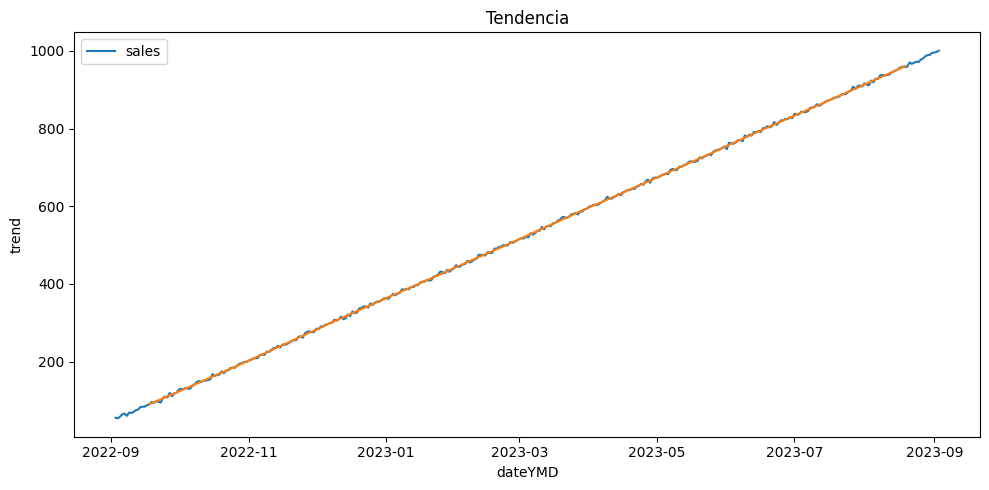

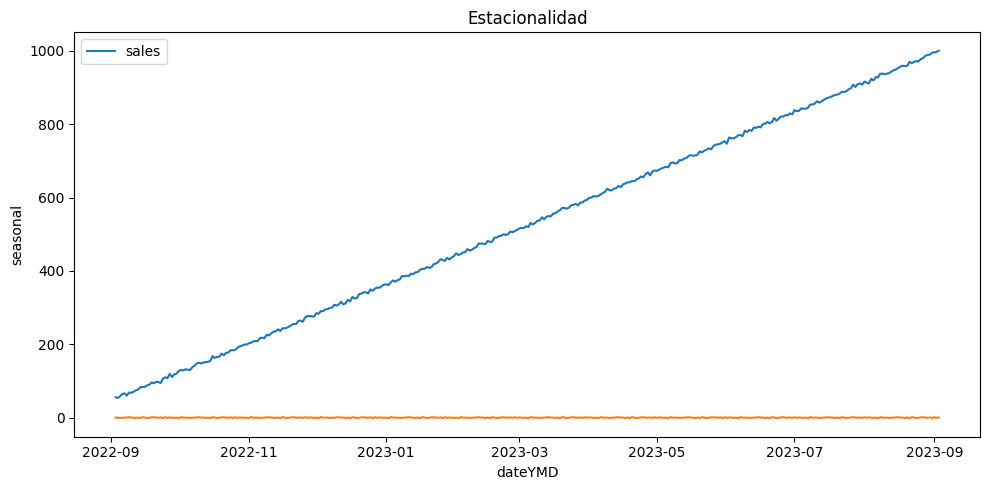

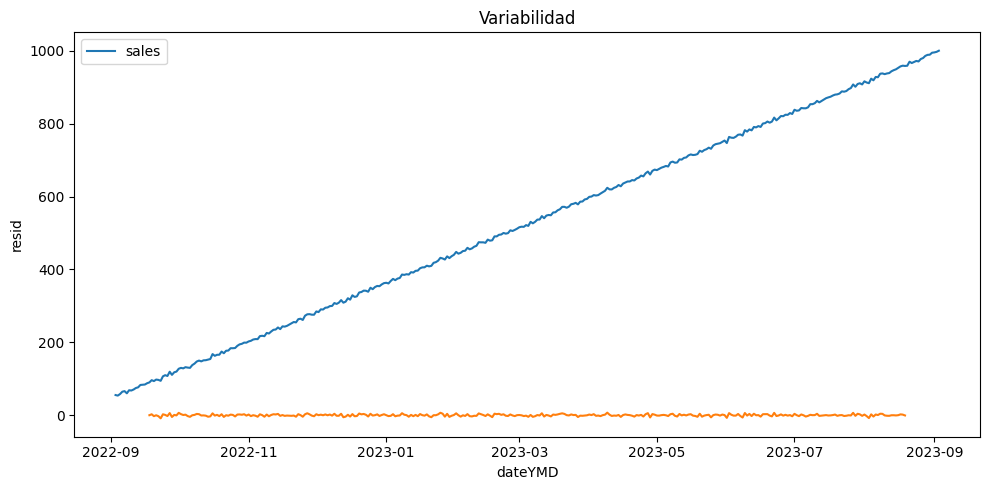

In [ ]:
'''
Paso 2: Construye y analiza la serie temporal
Construye la estructura de datos válida para la serie temporal, grafícala y, a continuación, analízala y responde a las siguientes preguntas:
A¿Cuál es el tensor de la serie temporal? El tensor de la unidad temporal son dias, en concreto es una serie de datos comprendidos en 366 tensores, 366 dias.
B¿Cuál es la tendencia? La tendencia es lineal positiva, la grafica incrementa de valor dia a dia, presenta ruidos(valores que decrementan e incrementan localmente pero muy leves). En general los valores van incrementando linealmente de forma positiva.
C¿Es estacionaria? No, no completa el numero de  ciclos de un mes por un año comprendido en 366 muestras, acabando muchos ciclos 11,8 aprox pero no cerrandolo en 12.
D¿Existe variabilidad o presencia de ruido? Apenas perceptible, el ruido que presenta es de poca intensidad y se aprecia claramente una linea en incremento.
'''
tensor = df_ds['sales'].count()
print(tensor,'es el tensor, igual al numero de muestras(Nuestro ciclo es mensual:31 muestras.):',tensor/31,'ciclos')
seasonal = decomposition.seasonal
trend = decomposition.trend
residual = decomposition.resid
fig, axis = plt.subplots(figsize = (10, 5))
plt.title('Tendencia')
sns.lineplot(data = df_ds)
sns.lineplot(data = trend)
plt.tight_layout()
plt.show()
fig, axis = plt.subplots(figsize = (10, 5))
plt.title('Estacionalidad')
sns.lineplot(data = df_ds)
sns.lineplot(data = seasonal)
plt.tight_layout()
plt.show()
fig, axis = plt.subplots(figsize = (10, 5))
plt.title('Variabilidad')
sns.lineplot(data = df_ds)
sns.lineplot(data = residual)
plt.tight_layout()
plt.show()

In [55]:
'''
Paso 3: Entrena un ARIMA:
Utiliza los datos de entrenamiento para encontrar la mejor parametrización de tu modelo ARIMA.
Vamos a analizar el timeseries con la prueba dickey-fuller y en funcion de los resultados, trabajaremos con
el ARIMA.
'''
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput
print(test_stationarity(df_rd_YMD))
'''Hemos de realizar el test fuller con el datraframe donde la fecha no sea el indice default del dataframe, importante.'''

Resultados de la prueba de Dickey-Fuller:
Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64


'Hemos de realizar el test fuller con el datraframe donde la fecha no sea el indice default del dataframe, importante.'

2.C)Como nos indica el p-value, rechazamos la hipotesis nula de estacionalidad. El p-value debe valer <0.05 para que sea estacionaria.